<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/MRtoCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MR to CT

## Step 1: Setup the Environment

In [7]:
# Install required libraries
!pip install datasets torch torchvision matplotlib scikit-learn

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import io

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Step 2: Load and Explore the Dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5120
})
Number of samples: 5120
Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'], id=None)}
Sample keys: dict_keys(['image', 'label'])
Label: 2


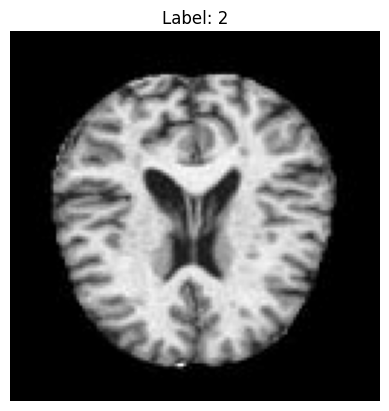

In [8]:
# Load the dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Explore the dataset
print(dataset)
print(f"Number of samples: {len(dataset)}")
print(f"Features: {dataset.features}")

# Example: View the first sample
sample = dataset[0]
print(f"Sample keys: {sample.keys()}")
print(f"Label: {sample['label']}")

# Display the first image (assuming 'image' is the key for MRI scans)
plt.imshow(sample['image'], cmap='gray')
plt.title(f"Label: {sample['label']}")
plt.axis('off')
plt.show()

## Step 3: Preprocess the Data

In [9]:
# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (adjust as needed)
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, so 1 channel)
])

# Custom Dataset class
class MRIDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']  # Adjust key if needed
        label = self.dataset[idx]['label']  # Adjust key if needed

        # Convert image to PIL if it's not already
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image))

        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset instance
mri_dataset = MRIDataset(dataset, transform=transform)

# Split into train and validation sets
train_idx, val_idx = train_test_split(range(len(mri_dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(mri_dataset, train_idx)
val_dataset = torch.utils.data.Subset(mri_dataset, val_idx)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 4096
Validation samples: 1024


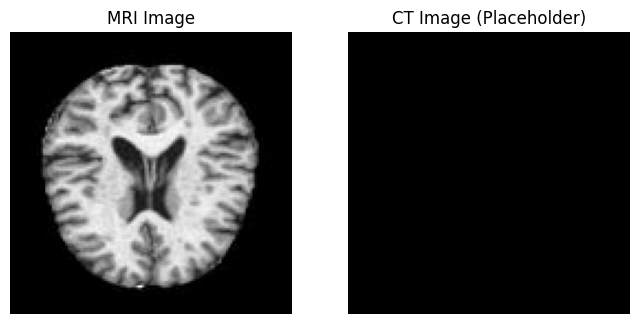

In [10]:
# Load the MRI dataset
mri_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (as per the paper's input size)
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, so 1 channel)
])

# Custom Dataset class for MRI (and placeholder for CT)
class ImageDataset(Dataset):
    def __init__(self, mri_dataset, ct_dataset=None, transform=None):
        self.mri_dataset = mri_dataset
        self.ct_dataset = ct_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mri_dataset)

    def __getitem__(self, idx):
        mri_image = self.mri_dataset[idx]['image']  # Adjust key if needed
        if not isinstance(mri_image, Image.Image):
            mri_image = Image.fromarray(np.array(mri_image))

        if self.transform:
            mri_image = self.transform(mri_image)

        # Placeholder for CT image
        if self.ct_dataset:
            ct_image = self.ct_dataset[idx]['image']  # Adjust key if needed
            if not isinstance(ct_image, Image.Image):
                ct_image = Image.fromarray(np.array(ct_image))
            if self.transform:
                ct_image = self.transform(ct_image)
        else:
            # Without CT data, we return a placeholder (zeros)
            ct_image = torch.zeros_like(mri_image)

        return mri_image, ct_image

# Create dataset instance (CT dataset is a placeholder for now)
dataset = ImageDataset(mri_dataset, ct_dataset=None, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize a sample
mri_img, ct_img = dataset[0]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(mri_img.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ct_img.squeeze(), cmap='gray')
plt.title("CT Image (Placeholder)")
plt.axis('off')
plt.show()

## Step 3: Define the Generator

In [11]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(9)])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# Initialize Generators
G_MRI_to_CT = Generator().to(device)
G_CT_to_MRI = Generator().to(device)

## Step 4: Define the Discriminators

In [12]:
# Discriminator (both Appearance and Structural)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize Discriminators
D_MRI = Discriminator().to(device)  # For MRI domain
D_CT = Discriminator().to(device)   # For CT domain